## Linear regression

This exercise is described in [ex1.pdf](data/ml-ex1/ex1.pdf).

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from mpl_toolkits.mplot3d import Axes3D
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

%matplotlib inline

### Linear regression with one variable

In [63]:
# Load data from CSV file
# - column 1: population (x)
# - column 2: profit (y)
data = np.loadtxt('data/ml-ex1/ex1data1.txt', delimiter=',')

In [64]:
data[0:5] # first 5 data points

array([[ 6.1101, 17.592 ],
       [ 5.5277,  9.1302],
       [ 8.5186, 13.662 ],
       [ 7.0032, 11.854 ],
       [ 5.8598,  6.8233]])

In [65]:
# Separate features (x) from target (y)
# Split array into 2 sub-arrays horizontally (column-wise)
X, y = np.hsplit(data, 2)

In [66]:
# Number of examples
m = y.size

In [67]:
# Fit a linear regression model (without regularization)
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [68]:
# Obtain coefficients theta0 and theta1 from model
theta0, theta1 = model.intercept_, model.coef_[0]
theta0, theta1

(array([-3.89578088]), array([1.19303364]))

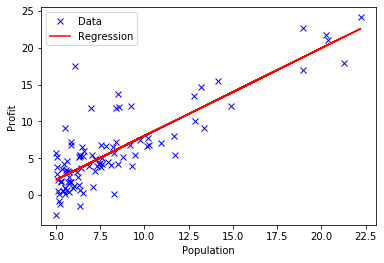

In [69]:
# Plot data and regression line
plt.plot(X, y, 'bx', label='Data')
plt.plot(X, model.predict(X), 'r-', label='Regression')
plt.xlabel('Population')
plt.ylabel('Profit')
plt.legend()

In [71]:
# Training mean squared error (part of the cost function)
np.mean((model.predict(X) - y) ** 2)

8.953942751950358

In [72]:
# Training score
model.score(X, y)

0.7020315537841397

The coefficient R^2 is defined as (1 - u/v), where u is the residual sum of squares ((y_true - y_pred) ** 2).sum() and v is the total sum of squares ((y_true - y_true.mean()) ** 2).sum(). **The best possible score is 1.0** and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

- [Source](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

In [73]:
# Predict profit for populations of 35.000 and 70.000 
model.predict(np.array([[3.5], [7.0]])) * 10000

array([[ 2798.36876352],
       [44554.54631015]])

See also [this Stackoverflow entry](https://stackoverflow.com/questions/34170618/normal-equation-and-numpy-least-squares-solve-methods-difference-in-regress) for the following calculations:

In [74]:
# LinearRegression above internally added a column (size = m) vector of Ones (1's).
# For the following calculations, this must be done explicitly.
# numpy.c_ ==> Translates slice objects to concatenation along the second axis
X = np.c_[np.ones(m), X]

In [75]:
# Compute least-squares solution with np.linalg.lstsq. 
# This is what LinearRegression actually does under the hood.
Theta = np.linalg.lstsq(X, y)[0]
Theta

/Users/sadeed/opt/anaconda3/envs/my37env/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[-3.89578088],
       [ 1.19303364]])

In [76]:
# Solve analytically using (without explicit inverse). numpy.dot(a, b) is the dot product of a . b
Theta = np.linalg.solve(X.T.dot(X), X.T.dot(y))
Theta

array([[-3.89578088],
       [ 1.19303364]])

In [77]:
# Solve normal equation (explicit inverse)
Theta = np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)
Theta

array([[-3.89578088],
       [ 1.19303364]])

In [78]:
# Solve normal equation (explicit pseudo-inverse)
Theta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
Theta

array([[-3.89578088],
       [ 1.19303364]])

In [79]:
# Cost function (mean squared error)
def cost(X, y, Theta):
    diff = X.dot(Theta) - y
    return np.sum(diff * diff, axis=0) / y.size

Text(0.5, 1.0, 'Cost function')

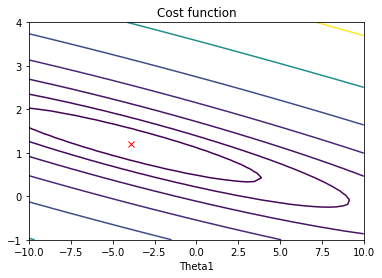

In [80]:
# np.mgrid[-1:1:5j] will return: array([-1. , -0.5,  0. ,  0.5,  1. ])
# Create a 50*50 grid for Theta0 and Theta1 ranges
Theta_grid = np.mgrid[-10:10:50j, -1:4:50j]

# Theta values in an array of shape (2500,2)
Thetas = np.c_[Theta_grid[0].ravel(), Theta_grid[1].ravel()]

# Compute costs on grid points
costs = cost(X, y, Thetas.T)

# Cost values reshaped to grid
cost_grid = costs.reshape(Theta_grid[0].shape)

# Contour plot of cost function
plt.contour(Theta_grid[0], Theta_grid[1], cost_grid, levels=[20, 40, 80, 160, 320, 640, 1280])

# Plot optmimum
plt.plot(Theta[0], Theta[1], 'rx')

# Title and axis labels
plt.xlabel('Theta0')
plt.xlabel('Theta1')
plt.title('Cost function')

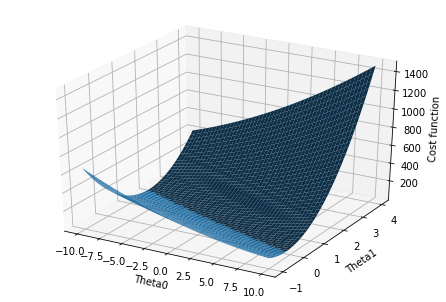

In [92]:
fig = plt.figure()
ax = Axes3D(fig)

ax.plot_surface(Theta_grid[0], Theta_grid[1], cost_grid)

ax.set_xlabel('Theta0')
ax.set_ylabel('Theta1')
ax.set_zlabel('Cost function')


plt.show()

### Linear regression with multiple variables

In [105]:
# Load data from CSV file
# - column 1: house size in feet**2 (x1)
# - column 2: number of bedrooms (x2)
# - column 3: house price (y)
data = np.loadtxt('data/ml-ex1/ex1data2.txt', delimiter=',')

In [106]:
# Separate features (x1, x2) from target (y)
X, y = np.hsplit(data, np.array([2]))

In [107]:
# Number of examples
m = y.size

By looking at the values, note that house sizes are about
1000 times the number of bedrooms. When features differ by orders of magnitude, first performing feature scaling can make gradient descent converge
much more quickly.

In [108]:
# Pipeline components

# sklearn.preprocessing.StandardScaler: Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()

regr = LinearRegression()

# Pipeline of feature scaler and linear regressor
model = Pipeline([('scaler', scaler), ('regr', regr)])

In [109]:
# Run linear regression on scaled features
model.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()), ('regr', LinearRegression())])

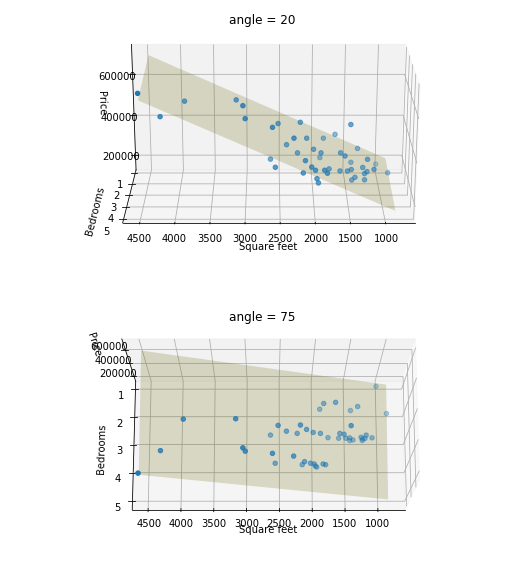

In [98]:
# Create a grid from feature min and max values
grid_range = np.vstack([X.min(axis=0), X.max(axis=0)])
grid = np.meshgrid(grid_range[:,0], grid_range[:,1])

# Compute predictions from grid values
X_grid = np.c_[grid[0].ravel(), grid[1].ravel()]
y_grid = model.predict(X_grid).reshape(grid[0].shape)

def plot_data_and_regression(fig, fignum, view_angle):
    sp = fig.add_subplot(2, 1, fignum, projection='3d')
    sp.view_init(view_angle, 90)
    sp.set_xlabel('Square feet')
    sp.set_ylabel('Bedrooms')
    sp.set_zlabel('Price')
    sp.set_title(f'angle = {view_angle}')
    # Customize tick locators
    sp.yaxis.set_major_locator(ticker.MultipleLocator(1.00))
    sp.zaxis.set_major_locator(ticker.MultipleLocator(200000))
    # Plot examples
    sp.scatter(X[:,0], X[:,1], y)
    # Plot regression area
    sp.plot_surface(grid[0], grid[1], y_grid, color='y', alpha=0.2)

# Create new figure
fig = plt.figure(2, figsize=[9, 10])
 
# Plot data and regression from two different angles
plot_data_and_regression(fig, fignum=1, view_angle=20)
plot_data_and_regression(fig, fignum=2, view_angle=75)

In [99]:
# Training mean squared error
np.mean((model.predict(X) - y) ** 2)

4086560101.2056565

In [100]:
# Training score
model.score(X, y)

0.73294501802891432

See also [this Stackoverflow entry](https://stackoverflow.com/questions/34170618/normal-equation-and-numpy-least-squares-solve-methods-difference-in-regress) for the following calculations:

In [101]:
# Add a column of 1s
X = np.c_[np.ones(m), X]

In [102]:
# Solve analytically (without explicit inverse)
Theta = np.linalg.solve(X.T.dot(X), X.T.dot(y))
Theta

array([[ 89597.9095428 ],
       [   139.21067402],
       [ -8738.01911233]])

In [103]:
# Solve normal equation (explicit pseudo-inverse)
Theta = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)
Theta

array([[ 89597.90954355],
       [   139.21067402],
       [ -8738.01911255]])

In [104]:
# Compute cost of solution
cost(X, y, Theta)

array([  4.08656010e+09])